<a href="https://colab.research.google.com/github/lucas-fpaiva/AnalisePred_I/blob/main/Projeto/car_eval/classifier_car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [172]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Avaliar a popularidade de músicas de forro

In [125]:
import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import seaborn as sns

from scipy.io.arff import loadarff 
from scipy.io import arff

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression

from sklearn.metrics import precision_score as ps
from sklearn.metrics import recall_score as rs
from sklearn.metrics import f1_score as f1
from sklearn.metrics import accuracy_score as acs

from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.datasets import make_classification
from ast import literal_eval

import warnings
warnings.filterwarnings('ignore')


In [2]:
def grid_best_model (model="DT", names=False, grid="", task="R"):
  #A função retorna o modelo com os melhores parametros, os melhores parametros e o melhor score
  scoring = 'accuracy'
  #models = ["KNN","LM","DT","SVM", "RF", "MLP", "GB", "ADA"]
  #types = ["C","R"]
  if names == True:
    print("KNN: KNeighborsRegressor\nLM: LinearRegression\nDT: DecisionTreeRegressor\nRF: RandomForestRegressor",
          "\nGB: GradientBoostingRegressor\nSVM: Support Vector Machine\nADA: AdaBoostRegressor\nMLP: MLPRegressor")
    
  if model == "DT":
    if task == "C":
      gs_cv = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=grid['DT'], cv= 5, scoring=scoring)
      gs_cv.fit(x_treino, y_treino)
      return DecisionTreeClassifier(criterion=gs_cv.best_params_['criterion'], max_depth=gs_cv.best_params_['max_depth'], min_samples_leaf=gs_cv.best_params_['min_samples_leaf'], 
                                    random_state=gs_cv.best_params_['random_state']).fit(x_treino, y_treino), gs_cv.best_params_

    elif task == "R":
      gs_cv = GridSearchCV(estimator=DecisionTreeRegressor(), param_grid=grid['DT'], cv= 5, scoring=scoring, n_jobs=-1)
      gs_cv.fit(x_treino, y_treino)
      return DecisionTreeRegressor(criterion=gs_cv.best_params_['criterion'], max_depth=gs_cv.best_params_['max_depth'], min_samples_leaf=gs_cv.best_params_['min_samples_leaf'],
                                   random_state=gs_cv.best_params_['random_state']).fit(x_treino, y_treino), gs_cv.best_params_
        
  if model=="MLP":
    if task == "C":
      gs_cv = GridSearchCV(estimator=MLPClassifier(), param_grid=grid['MLP'], cv= 5, scoring=scoring, n_jobs=-1)
      gs_cv.fit(x_treino, y_treino)
      return MLPClassifier(hidden_layer_sizes=gs_cv.best_params_['hidden_layer_sizes'], max_iter=gs_cv.best_params_['max_iter'], activation=gs_cv.best_params_['activation'], 
                           random_state=gs_cv.best_params_['random_state']), gs_cv.best_params_
    elif task == "R":

      gs_cv = GridSearchCV(estimator=MLPRegressor(), param_grid=grid['MLP'], cv= 5, scoring=scoring, n_jobs=-1)
      gs_cv.fit(x_treino, y_treino)
      return MLPRegressor(early_stopping=True, hidden_layer_sizes=gs_cv.best_params_['hidden_layer_sizes'], max_iter=gs_cv.best_params_['max_iter'], activation=gs_cv.best_params_['activation'], 
                           random_state=gs_cv.best_params_['random_state']), gs_cv.best_params_
    
  if model == "RF":
    if task == "C":
      gs_cv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid['RF'], cv= 5, scoring=scoring, n_jobs=-1)
      gs_cv.fit(x_treino, y_treino)
      return RandomForestClassifier(n_estimators=gs_cv.best_params_['n_estimators'], max_depth=gs_cv.best_params_['max_depth'], max_features=gs_cv.best_params_['max_features'], 
                             random_state=gs_cv.best_params_['random_state'], criterion=gs_cv.best_params_['criterion']), gs_cv.best_params_

    elif task == "R":
      gs_cv = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid['RF'], cv= 5, scoring=scoring, n_jobs=-1)
      gs_cv.fit(x_treino, y_treino)
      return RandomForestRegressor(n_estimators=gs_cv.best_params_['n_estimators'], max_features=gs_cv.best_params_['max_features'], 
                             random_state=gs_cv.best_params_['random_state'], criterion=gs_cv.best_params_['criterion']), gs_cv.best_params_

  if model == "KNN":
    if task == "C":
      gs_cv = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=grid['KNN'], cv= 5, scoring=scoring, n_jobs=-1)
      gs_cv.fit(x_treino, y_treino)
      return KNeighborsClassifier(n_neighbors=gs_cv.best_params_['n_neighbors'], weights=gs_cv.best_params_['weights'], metric=gs_cv.best_params_['metric']), gs_cv.best_params_

    elif task == "R":
      gs_cv = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=grid['KNN'], cv= 5, scoring=scoring, n_jobs=-1)
      gs_cv.fit(x_treino, y_treino)
      return KNeighborsRegressor(n_neighbors=gs_cv.best_params_['n_neighbors'], weights=gs_cv.best_params_['weights'], metric=gs_cv.best_params_['metric']), gs_cv.best_params_

  if model == "LM":
    if task == "C":
      gs_cv = GridSearchCV(estimator=LogisticRegression(), param_grid=grid['LM'], cv= 5, scoring=scoring, n_jobs=-1)
      gs_cv.fit(x_treino, y_treino)
      return LogisticRegression(fit_intercept=gs_cv.best_params_['fit_intercept']), gs_cv.best_params_

    elif task == "R":
      gs_cv = GridSearchCV(estimator=LinearRegression(), param_grid=grid['LM'], cv= 5, scoring=scoring, n_jobs=-1)
      gs_cv.fit(x_treino, y_treino)
      return LinearRegression(fit_intercept=gs_cv.best_params_['fit_intercept']), gs_cv.best_params_
        
  return print("KNN: KNeighborsRegressor\nLM: LinearRegression\nDT: DecisionTreeRegressor\nRF: RandomForestRegressor",
          "\nGB: GradientBoostingRegressor\nSVM: Support Vector Machine\nADA: AdaBoostRegressor\nMLP: MLPRegressor")
  
#Parâmetros do Grid
grid = {
    'RF':{ 
        'n_estimators': range(5,30,2),
        'max_depth' : range(5,30,2),
        'criterion' :['gini', 'entropy'],
        'random_state' : [0]},

    'MLP':{
        'hidden_layer_sizes': range(5,30,2),#[(10,), (15,), (20,), (30,)],
        'max_iter': [200],
        'activation' : ['relu', 'tanh'],
        'random_state' : [0]},

    'DT':{
        'max_depth': range(5,30,2),
        'min_samples_leaf': [1,2,3,4,5],
        'criterion' :['gini', 'entropy'],
        'random_state' : [0]},

    'KNN':{
      'n_neighbors': range(5,30,2),
      'weights': ['uniform', 'distance'],
      'metric' : ['manhattan', 'euclidean']},

    'LM':{
      'fit_intercept' : [True, False]}
}

In [143]:

data['class'].values

array([0, 0, 0, ..., 0, 3, 2])

In [165]:
def data_k_fold(data, k, tag, id_tag, features):
    kf=StratifiedKFold(n_splits=k, shuffle=True, random_state=123)
    kf.get_n_splits(data[tag].values)
    ids = np.array(data[id_tag])
    folds = pd.DataFrame([], columns=[id_tag, 'fold'])
    k=1
    
    for train_index, test_index in kf.split(data[features], data[tag]):
      fold = np.array([k]*len(test_index))
      folds = pd.concat([folds, pd.DataFrame(np.transpose([ids[test_index],fold]),columns=[id_tag, 'fold'])])
      k+=1

    data = data.merge(folds, how='left',on=id_tag)   
    return data

## Lendo o Dataset

In [4]:
!git clone 'https://github.com/lucas-fpaiva/AnalisePred_I.git'

Cloning into 'AnalisePred_I'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 139 (delta 40), reused 11 (delta 1), pack-reused 0
Receiving objects: 100% (139/139), 5.28 MiB | 5.62 MiB/s, done.
Resolving deltas: 100% (40/40), done.


In [160]:
data = loadarff('/content/AnalisePred_I/Projeto/car_eval/car-evaluation.arff')
data = pd.DataFrame(data[0])

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   class                    1728 non-null   object
 1   buying_price_vhigh       1728 non-null   object
 2   buying_price_high        1728 non-null   object
 3   buying_price_med         1728 non-null   object
 4   buying_price_low         1728 non-null   object
 5   maintenance_price_vhigh  1728 non-null   object
 6   maintenance_price_high   1728 non-null   object
 7   maintenance_price_med    1728 non-null   object
 8   maintenance_price_low    1728 non-null   object
 9   doors_2                  1728 non-null   object
 10  doors_3                  1728 non-null   object
 11  doors_4                  1728 non-null   object
 12  doors_5more              1728 non-null   object
 13  persons_2                1728 non-null   object
 14  persons_4                1728 non-null  

## Tratando o DataSet

In [161]:
# Convertendo os valores em bytes para int
for col in data.columns:
    data[col] = data[col].astype(int)

In [162]:
data['id'] = data.index

In [114]:
data.buying_price_vhigh.value_counts()

0    1296
1     432
Name: buying_price_vhigh, dtype: int64

In [163]:
data.head()

,class,buying_price_vhigh,buying_price_high,buying_price_med,buying_price_low,maintenance_price_vhigh,maintenance_price_high,maintenance_price_med,maintenance_price_low,doors_2,...,persons_2,persons_4,persons_more,luggage_boot_size_small,luggage_boot_size_med,luggage_boot_size_big,safety_low,safety_med,safety_high,id
0,0,1,0,0,0,1,0,0,0,1,...,1,0,0,1,0,0,1,0,0,0
1,0,1,0,0,0,1,0,0,0,1,...,1,0,0,1,0,0,0,1,0,1
2,0,1,0,0,0,1,0,0,0,1,...,1,0,0,1,0,0,0,0,1,2
3,0,1,0,0,0,1,0,0,0,1,...,1,0,0,0,1,0,1,0,0,3
4,0,1,0,0,0,1,0,0,0,1,...,1,0,0,0,1,0,0,1,0,4


In [166]:
data = data_k_fold(data, 5, 'class', 'id', data.columns[1:-1])

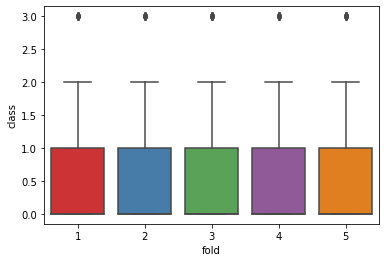

In [167]:
sns.boxplot(data = data, y='class',x='fold',palette='Set1')

## Avaliando a Árvore de Decisão

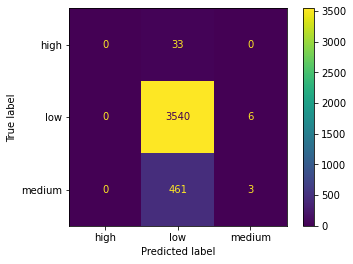

In [ ]:
plot_confusion_matrix(model, x_teste, y_teste)

In [168]:
def get_accuracies(true_labels, predictions):
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.multilabel_confusion_matrix.html
    cm = multilabel_confusion_matrix(true_labels, predictions)
    total_count = true_labels.shape[0]
    accuracies = []
    for i in range(3):
        true_positive_count = np.sum(cm[i,1,1]).item()
        true_negative_count = np.sum(cm[i,0,0]).item()
        accuracy = (true_positive_count + true_negative_count) / total_count
        accuracies.append(accuracy)
    return accuracies

def metrics (y_true, y_pred):
  return [acs(y_true, y_pred), get_accuracies(y_true, y_pred), ps(y_true, y_pred, average = 'weighted'), 
          f1(y_true, y_pred, average = 'weighted'), rs(y_true, y_pred, average = 'weighted')]

Melhor parametro: {'fit_intercept': True}
Fold 1 [0.9161849710982659, [0.953757225433526, 0.9190751445086706, 0.9942196531791907], 0.9152714105375058, 0.9090182809342545, 0.9161849710982659]


<Figure size 432x288 with 0 Axes>

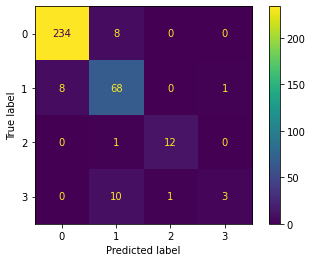

Melhor parametro: {'fit_intercept': True}
Fold 2 [0.9421965317919075, [0.9739884393063584, 0.9450867052023122, 0.9942196531791907], 0.9444108070534866, 0.9383173093775625, 0.9421965317919075]


<Figure size 432x288 with 0 Axes>

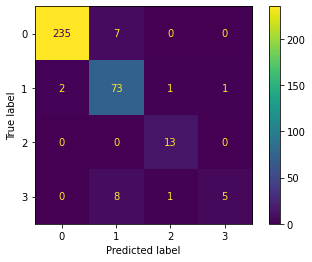

Melhor parametro: {'fit_intercept': True}
Fold 3 [0.884393063583815, [0.9248554913294798, 0.8959537572254336, 0.9913294797687862], 0.8803516224109736, 0.880187234675815, 0.884393063583815]


<Figure size 432x288 with 0 Axes>

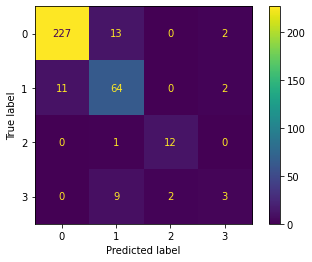

Melhor parametro: {'fit_intercept': True}
Fold 4 [0.9246376811594202, [0.9478260869565217, 0.9304347826086956, 0.991304347826087], 0.9261146302418295, 0.9245624168592032, 0.9246376811594202]


<Figure size 432x288 with 0 Axes>

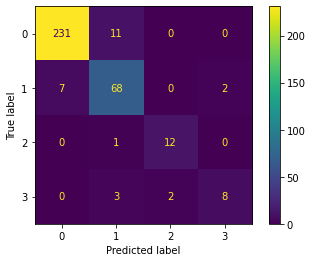

Melhor parametro: {'fit_intercept': True}
Fold 5 [0.9014492753623189, [0.9536231884057971, 0.9014492753623189, 0.9855072463768116], 0.905063726813977, 0.8979434092477571, 0.9014492753623189]


<Figure size 432x288 with 0 Axes>

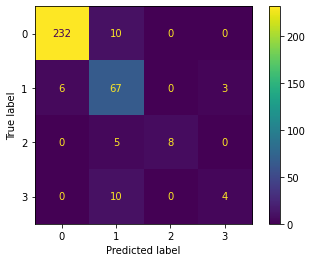

FileNotFoundError: ignored

In [173]:
data_results = pd.DataFrame([],columns=['accuracy', 'confusion_matrix', 'precision', 'f1_score','recall', 'fold','model','parameters'])
models = ["LM", "KNN", "MLP", "DT", "RF"]

for name_model in models:
  results = []
  for k in range(1,6):
    treino = data[data.fold!=k]
    teste  = data[data.fold==k]
    
    x_treino = treino.drop(['fold','id','class'], axis=1)
    y_treino = treino['class']

    x_teste = teste.drop(['fold','id','class'], axis=1)
    y_teste = teste['class']

    model, best_parameters = grid_best_model(model=name_model, grid=grid, task = "C")
    model.fit(x_treino, y_treino)
    y_pred= model.predict(x_teste)

    print("Melhor parametro:", best_parameters)         
    print("Fold", k, metrics(y_teste.values, y_pred))

    plt.figure()
    plot_confusion_matrix(model, x_teste, y_teste)
    plt.show()


    result = metrics(y_teste, y_pred)
    result.append(k)
    result.append(name_model)
    result.append(best_parameters)
    
    results.append(result)
        
  data_results = pd.concat([data_results, pd.DataFrame(results,columns=['accuracy', 'confusion_matrix', 'precision', 'f1_score','recall', 'fold','model','parameters'])])
  data_results.to_csv('/content/drive/MyDrive/AnalisePred_I/Car_results_'+ name_model + '.csv')


In [ ]:
print(data_results['parameters'][4])

In [ ]:
data_results.mean()

### Predição do Modelo

In [ ]:
model.fit(x_treino, y_treino)
np.sqrt(model.score(x_treino, y_treino))

In [ ]:
model.score(x_teste, y_teste)

In [ ]:
y_pred_t = model.predict(x_treino)

In [ ]:
y_pred= model.predict(x_teste)

In [ ]:
plt.plot(y_treino, y_pred_t, 'o')

plt.plot(y_teste, y_pred, 'x')


#### MAPE

In [ ]:
mape(y_teste,y_pred)*100

In [ ]:
plt.plot(((y_teste.values - y_pred)/y_teste.values)*100)
np.mean(100*np.abs(y_teste.values - y_pred)/y_teste.values)

#### Plot do Modelo Teste x Treino

In [ ]:
plt.plot(y_teste.values, 'o')
plt.plot(y_pred, 'x')
plt.xlim([100,300])
plt.ylim([0,0.3])

In [ ]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true+0.00001))) * 100

In [ ]:
def mae (y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [ ]:
def r2_score(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))